# DCRNN-MLP for urban air temperature prediction

## Intro

This notebook is the base tool to reproduce the training of the graph-based model developed to forecast urban temperature timeseries (and UHI intenisty timeseries).

### Needed packages
- pytorch==2.5.0
- torchvision==0.20
- pytorch-geometric
- torch spatio-temporal (tsl)

In [ ]:
#install/downgrade torch to 2.5 (tsl not compatible with 2.6.0)
!pip install torch==2.5.0
!pip install torchvision==0.20
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-geometric \
  torch-sparse \
  torch-scatter \
  torch-cluster \
  -f https://pytorch-geometric.com/whl/torch-2.5.0+cu124.html

!pip install torch-spatiotemporal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.5 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found ex

### Imports

In [ ]:
import importlib
#import utils_data#importlib.reload(utils_data)
#from utils_data import *
import numpy as np

from tqdm import tqdm
import os
import tsl
import torch
from sklearn.preprocessing import StandardScaler
import pandas as pd
import geopandas as gpd
from scripts.graph_construction import create_graph_from_dataframe
from scripts.utils import *
from tsl.data.datamodule import SpatioTemporalDataModule, TemporalSplitter, AtTimeStepSplitter
from tsl.data.preprocessing import StandardScaler
from datetime import datetime
import matplotlib.pyplot as plt
from tsl.nn.models.temporal.rnn_model import RNNModel
from tsl.metrics.torch import MaskedMAE, MaskedMAPE, MaskedMSE, MaskedMetric, convert_to_masked_metric
from tsl.engines import Predictor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tsl.metrics.torch import convert_to_masked_metric




## 1. Data loading and cleaning


### Nodes static features dataframe

In [ ]:
dataset = gpd.read_file("/data/nodes_dataset.shp")


col_id = "Log_Nr"
numerical_columns = [col for col in dataset.columns if col not in ['latitude', 'longitude', "col_1", "col_2"]]
categorical_columns = ["col1", "col2"]

processed_dataset = clean_and_prepare_dataset(dataset, numerical_columns, categorical_columns, {'col_1':"mean", 'col_2':"median"})

### Nodes temporal dataframe

In [ ]:
timeseries = pd.read_csv("/data/nodes_timeseries.csv") # Timeseries dataframe should have a 'datetime' columns

timeseries['datetime'] = pd.to_datetime(timeseries['datetime'], format='mixed')
timeseries['hour'] = timeseries['datetime'].dt.floor('H')
timeseries_hourly = timeseries.groupby('hour').mean(numeric_only=True) #averaging for hourly values so that it matches the exgenous time.

#keep only the columns corresponding to the node_ids

cols_to_keep = [col for col in timeseries_hourly.columns[:] if int(col.split('_')[-1]) in dataset['col_id'].unique()]
timeseries_hourly_clean = timeseries_hourly[cols_to_keep]

timeseries_hourly_clean = remove_outliers_zscore(timeseries_hourly_clean, threshold=4.5) #remove outliers (0.0001% of the values here,the threshold arg is the z-score)

### Exogenous features

In [ ]:
# choose the type of setting: 
seasonal = True

In [ ]:
exog_df = pd.read_csv("exog_df.csv") #exogenous features (e.g. weather data), should contain a 'datetime' column

exog_df.rename(columns = {'time':'datetime'}, inplace=True)
exog_df['datetime'] = pd.to_datetime(exog_df['datetime'], format='mixed')
exog_df['hour'] = exog_df['datetime'].dt.hour
exog_df['month'] = exog_df['datetime'].dt.month
exog_df['day'] = exog_df['datetime'].dt.day
exog_df['year'] = exog_df['datetime'].dt.year

# build mask: months June–August OR (May and day ≥15) OR (September and day ≤15)
if seasonal:
  mask = (
      (exog_df['month'].between(6, 8)) |
      ((exog_df['month'] == 5)  & (exog_df['day']   >= 20)) |
      ((exog_df['month'] == 9)  & (exog_df['day']   <= 15))
  )
else:
  mask = exog_df['year'] >= 2023
  
exog_df = exog_df.sort_values('datetime')
exog_df['temperature_24h_ahead'] = exog_df['mean_hourly_temperature'].shift(-24)
exog_df = exog_df.dropna(subset=['temperature_24h_ahead'])
# apply mask
exog_df = exog_df.loc[mask].reset_index(drop=True)
#exog_df = exog_df[exog_df['year'] <= 2022]
exog_df = exog_df[exog_df['datetime'].isin(timeseries_hourly_clean.index)]

exog_df.drop(columns=['day', 'year'], inplace=True)
exog_df['hour_cos'] = np.cos(2 * np.pi * exog_df['hour'] / 24)
exog_df['hour_sin'] = np.sin(2 * np.pi * exog_df['hour'] / 24)
exog_df.drop(columns=['hour'], inplace=True)
print(exog_df.columns)
compute_col_corr(exog_df)


#make sur that the timeseries is synchnornized 
timeseries_hourly_clean = timeseries_hourly_clean.loc[exog_df.datetime]


In [ ]:
#Maybe remove exogenous features with too much correlation 
cols_to_remove = ['col1', 'col2', 'col3']
exog_df.drop(columns=cols_to_remove, inplace=True)

In [ ]:
#shift X hours ahed (X being the prediction horizon)
exog_df_X_h_ahead = exog_df.shift(-24)

## 2. Graph creation

In [ ]:

edge_index, edge_weights, weighted_adj, node_mapping = create_graph_from_dataframe(
    df=processed_dataset,
    feature_cols=[col for col in processed_dataset if col not in ['latitude', 'longitude', 'geometry', 'Log_Nr']],
    geo_cols=['latitude', 'longitude'],
    id_col='Log_Nr',
    k=10,
    feature_weight=0.6,
    geo_weight=0.4,
    weight_method='sigmoid'
)

Creating graph with 113 nodes
Feature data shape: (113, 26)
Geo data shape: (113, 2)
Weight distribution quantiles: [0.15529752 0.463016   0.53377807 0.61589421 0.9999972 ]
Edge weights - Min: 0.155298, Max: 0.999997, Mean: 0.541563
NaN values in weights: 0
Inf values in weights: 0


## 3. Prepare the dataset and datamodule for the model training

### Dataset

In [ ]:
#timeseries_hourly_clean = timeseries_hourly_clean.reindex(weather_df.datetime)
#choose the dateset configuration
model_args = {'horizon':24, #target len in the future
              'window': 24, #squence len in the past
              'stride':1} #timesteps between two windows
st_dataset, timestamps = create_st_dataset(processed_dataset,
                               timeseries_hourly_clean,
                               edge_index = edge_index,
                               edge_weight = edge_weights,
                               weather_df=exog_df_X_h_ahead.drop(columns=['temperature_24h_ahead', 'mean_hourly_temperature']), #dropping this for temperature prediction to avoid leakage
                               args=model_args)

<ipython-input-10-5ca0656a0ef8>:10: RuntimeWarning: All-NaN slice encountered
  row_median = np.nanmedian(row)


In [ ]:
#Create the datamodule (that separates the dataset into train, val, test and batches it)

# Split data sequentially:
#   |------------ dataset -----------|
#   |--- train ---|- val -|-- test --|
if seasonal:
  splitter = AtTimeStepSplitter(
      first_val_ts=datetime(2023, 5, 21, 0, 0, 0),
      first_test_ts=datetime(2024, 5, 15, 0, 0, 0),
      last_val_ts=datetime(2023, 9, 15, 1, 0, 0),
      last_test_ts=datetime(2024, 9, 15, 0, 0, 0)
  )
  batch_size = 128
else:
  splitter = TemporalSplitter(val_len=0.1, test_len = 0.2)
  batch_size = 128


dm = SpatioTemporalDataModule(
    dataset=st_dataset,
    splitter=splitter,
    batch_size=batch_size
)
dm.setup()

Train dataloader length: 89
Validation dataloader length: 22
Test dataloader length: 23


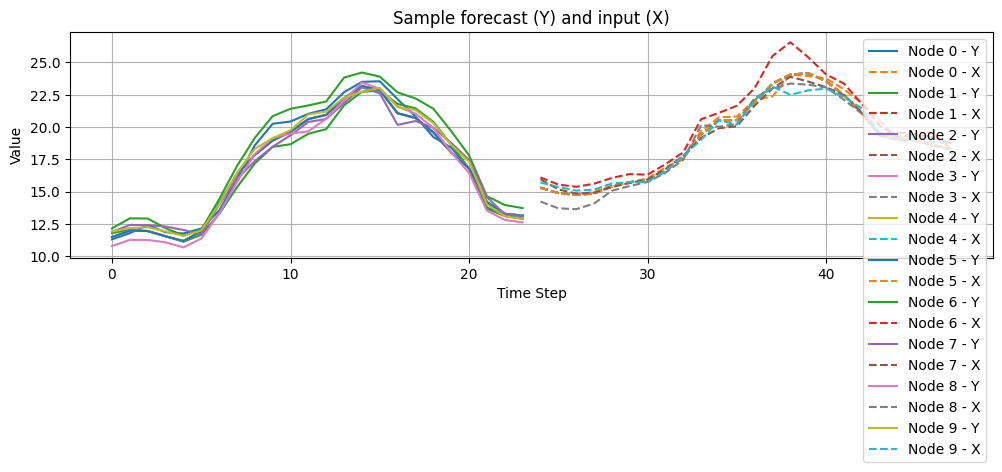

In [ ]:
# Print datamodule details
print("Train dataloader length:", len(dm.train_dataloader()))
print("Validation dataloader length:", len(dm.val_dataloader()))
print("Test dataloader length:", len(dm.test_dataloader()))

# Sample a batch to check shapes


for batch in dm.test_dataloader(shuffle=False):
    y = batch['y'][0, :, 0:10, 0].cpu().numpy()  # shape: (time, 10)
    x = batch['x'][0, :, 0:10, 0].cpu().numpy()  # shape: (time, 10)

    time_y = range(0, y.shape[0])
    time_x = range(y.shape[0], y.shape[0] + x.shape[0])

    plt.figure(figsize=(10, 4))
    for node in range(y.shape[1]):
        plt.plot(time_y, y[:, node], label=f'Node {node} - Y')
        plt.plot(time_x, x[:, node], '--', label=f'Node {node} - X')

    plt.title("Sample forecast (Y) and input (X)")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend(False)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    break


# 4. Create the model

## Define parameters

In [ ]:
ff_size = 64
n_layers = 2 
hidden_size = 64 
input_size = st_dataset.n_channels
n_nodes = st_dataset.n_nodes
horizon = st_dataset.horizon
exog_size = st_dataset.u.shape[1]
static_size = st_dataset.s.shape[-1]

## Baseline model

In [ ]:

baseline_model = RNNModel(
    input_size=input_size,
    exog_size=exog_size,
    horizon=horizon,
    hidden_size = hidden_size,
    ff_size = ff_size,
    activation = 'relu',
    rec_layers=1,
    cell_type='lstm',
    output_size=1)


## DCRNN-MLP

In [ ]:
from tsl.nn.blocks import DCRNN, MultiHorizonMLPDecoder
import torch.nn as nn

class DCRNN_MLP(nn.Module):
    def __init__(self, input_size, static_size, exog_size, output_size, context_size, horizon):
        super(DCRNN_MLP, self).__init__()
        self.encoder = DCRNN(input_size,
                             hidden_size=64,
                             k=2
                             )
        self.decoder = MultiHorizonMLPDecoder(
            input_size=64,
            hidden_size=64,
            output_size=output_size,
            exog_size=exog_size,
            n_layers=2,
            context_size=context_size,
            horizon=horizon)

    def forward(self, x, u, edge_index, edge_weight):
        x, last = self.encoder(x, edge_index, edge_weight)
        out = self.decoder(x, u)
        return out

model = DCRNN_MLP(
    input_size=input_size,
    static_size=static_size,
    exog_size=exog_size,
    output_size=1,
    context_size=64,
    horizon=24)

In [ ]:

def smape_fn(y_hat, y):
    denominator = (torch.abs(y) + torch.abs(y_hat)).clamp(min=1e-6)
    smape = 200.0 * torch.abs(y - y_hat) / denominator
    return smape


loss_fn = MaskedMSE(mask_nans=True)  # You could also use MaskedHuberLoss(mask_nans=True) as an alternative loss

metrics = {
    'mae': MaskedMAE(mask_nans=True),
    'mse': MaskedMSE(mask_nans=True),
}

class PredictorWithScheduler(Predictor):
    def configure_optimizers(self):
        optimizer = self.optim_class(self.model.parameters(), **self.optim_kwargs)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_mse',  # matches the monitored metric
            },
        }
# setup predictor
learning_rate = 0.001 #@param
predictor = PredictorWithScheduler(
    model=model,
    optim_class=torch.optim.AdamW,
    optim_kwargs={'lr': learning_rate},
    loss_fn=loss_fn,
    metrics=metrics,
)

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    dirpath='/content/logs',
    save_top_k=1,
    monitor='val_mse',
    mode='min',
)

early_stop_callback = EarlyStopping(monitor="val_mse", min_delta=1e-3, patience=10, verbose=True, mode="min")

trainer = pl.Trainer(max_epochs=100,
                     devices=1,
                     callbacks=[checkpoint_callback, early_stop_callback],
                     accelerator='gpu',
                     )

trainer.fit(predictor, datamodule=dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss_fn       | MaskedMSE              | 0      | train
1 | train_metrics | MetricCollection       | 0      | train
2 | val_metrics   | MetricCollection       | 0      | train
3 | test_metrics  | MetricCollection       | 0      | train
4 | model         | SpatioTemporalGNN_test | 187 K  | train
-----------------------------------------------------------------
187 K     Trainable params
0         Non-trainable params
187 K     Total params
0.752     Total estimated model params size (MB)
46

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved. New best score: 29.007


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 11.560 >= min_delta = 0.001. New best score: 17.447


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 5.221 >= min_delta = 0.001. New best score: 12.226


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 4.616 >= min_delta = 0.001. New best score: 7.610


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 1.462 >= min_delta = 0.001. New best score: 6.149


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.378 >= min_delta = 0.001. New best score: 5.771


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.029 >= min_delta = 0.001. New best score: 5.741


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.157 >= min_delta = 0.001. New best score: 5.585


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.011 >= min_delta = 0.001. New best score: 5.574


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.038 >= min_delta = 0.001. New best score: 5.535


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.263 >= min_delta = 0.001. New best score: 5.272


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.112 >= min_delta = 0.001. New best score: 5.160


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.089 >= min_delta = 0.001. New best score: 5.071


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.023 >= min_delta = 0.001. New best score: 5.048


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.134 >= min_delta = 0.001. New best score: 4.914


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.002 >= min_delta = 0.001. New best score: 4.912


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_mse did not improve in the last 10 records. Best score: 4.912. Signaling Trainer to stop.


In [ ]:
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")

Best model saved at: /content/logs/epoch=27-step=2492.ckpt


In [ ]:
checkpoint = torch.load(best_model_path)

# Initialize the predictor with the saved state_dict
predictor = PredictorWithScheduler(
    model=model,
    optim_class=torch.optim.AdamW,
    optim_kwargs={'lr': 0.001},
    loss_fn=loss_fn,
    metrics=metrics
)

# Load the state_dict manually
predictor.load_state_dict(checkpoint['state_dict'])

pred = trainer.test(predictor, datamodule=dm)
print(pred)

<ipython-input-34-2859c297ac46>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     5.416760444641113     │
│         test_mae          │    1.7269340753555298     │
│         test_mse          │     5.394720077514648     │
└───────────────────────────┴───────────────────────────┘

[{'test_mae': 1.7269340753555298, 'test_mse': 5.394720077514648, 'test_loss': 5.416760444641113}]


In [ ]:
pred = trainer.predict(predictor, dataloaders = dm.test_dataloader(), )

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

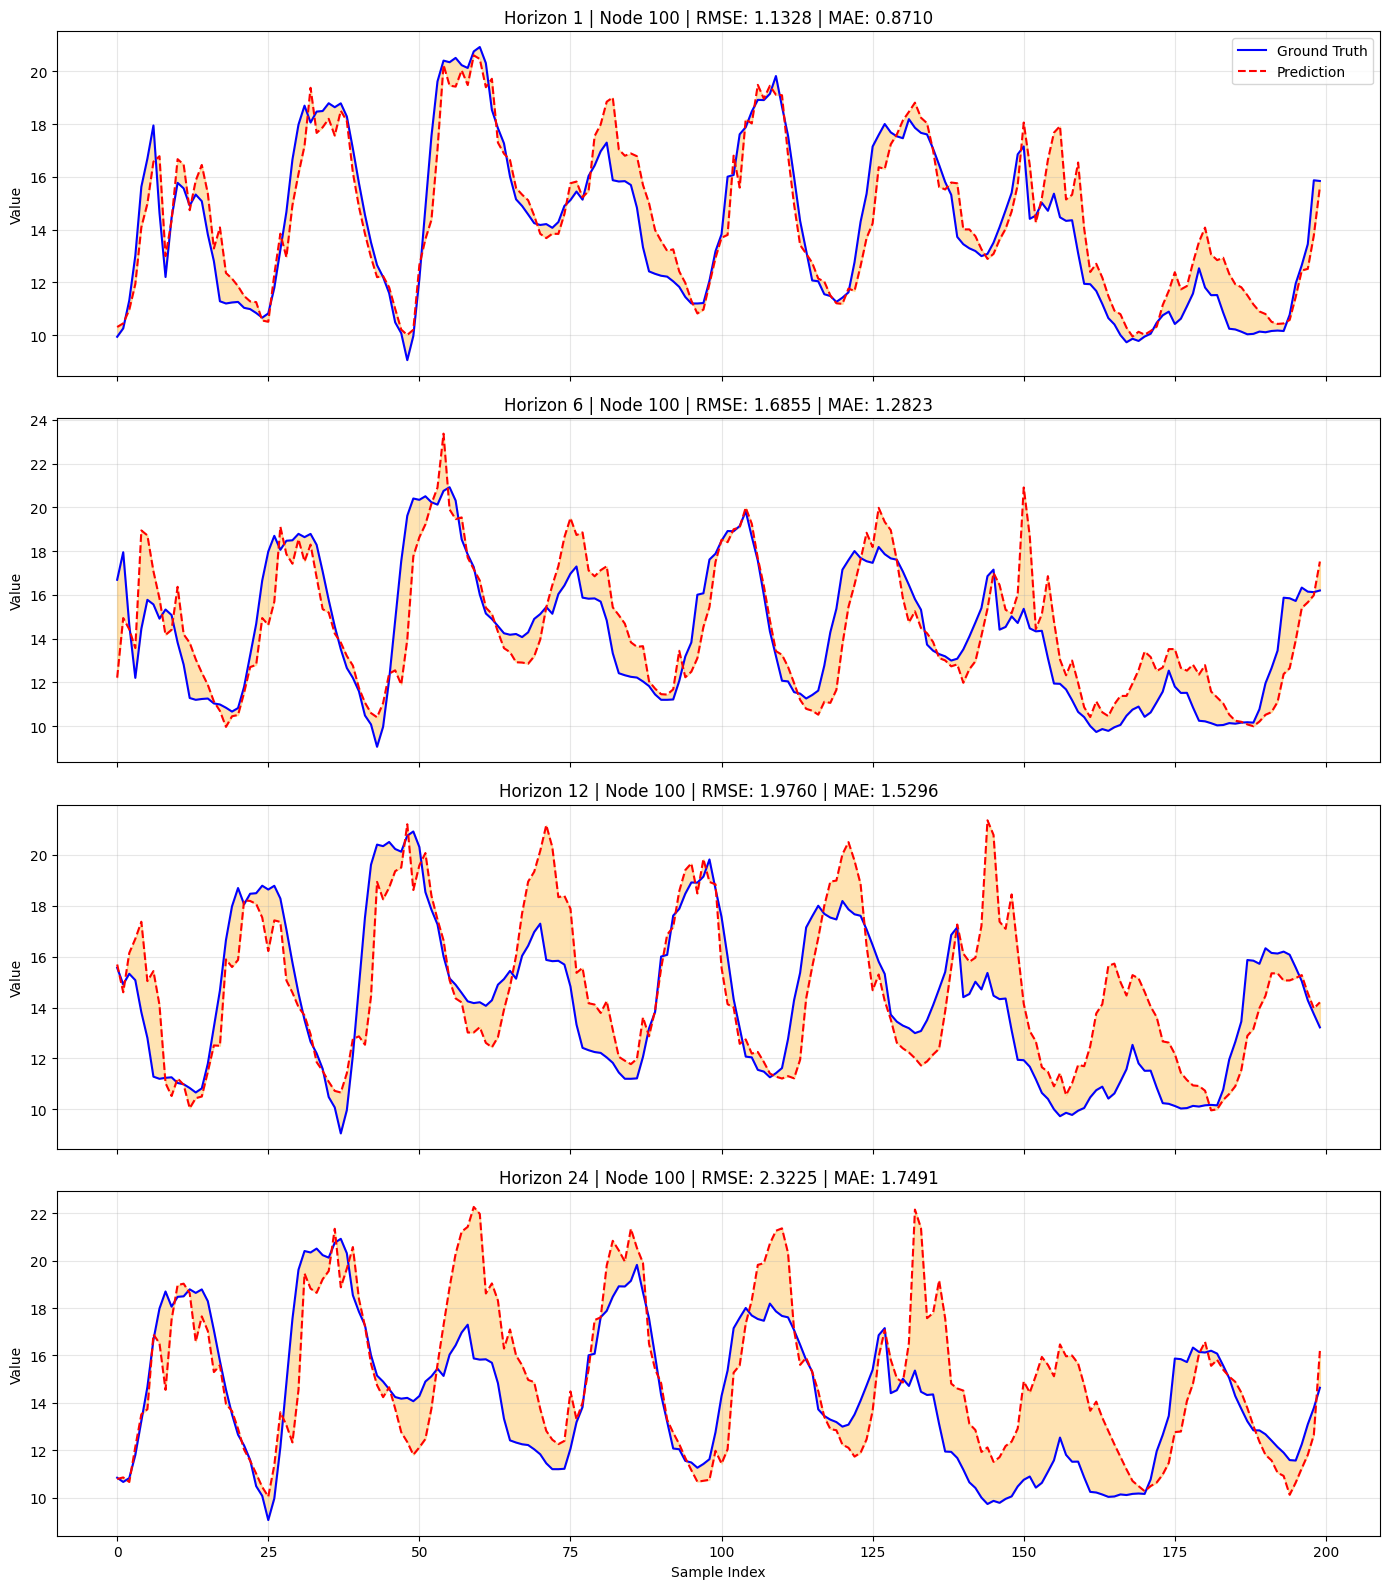

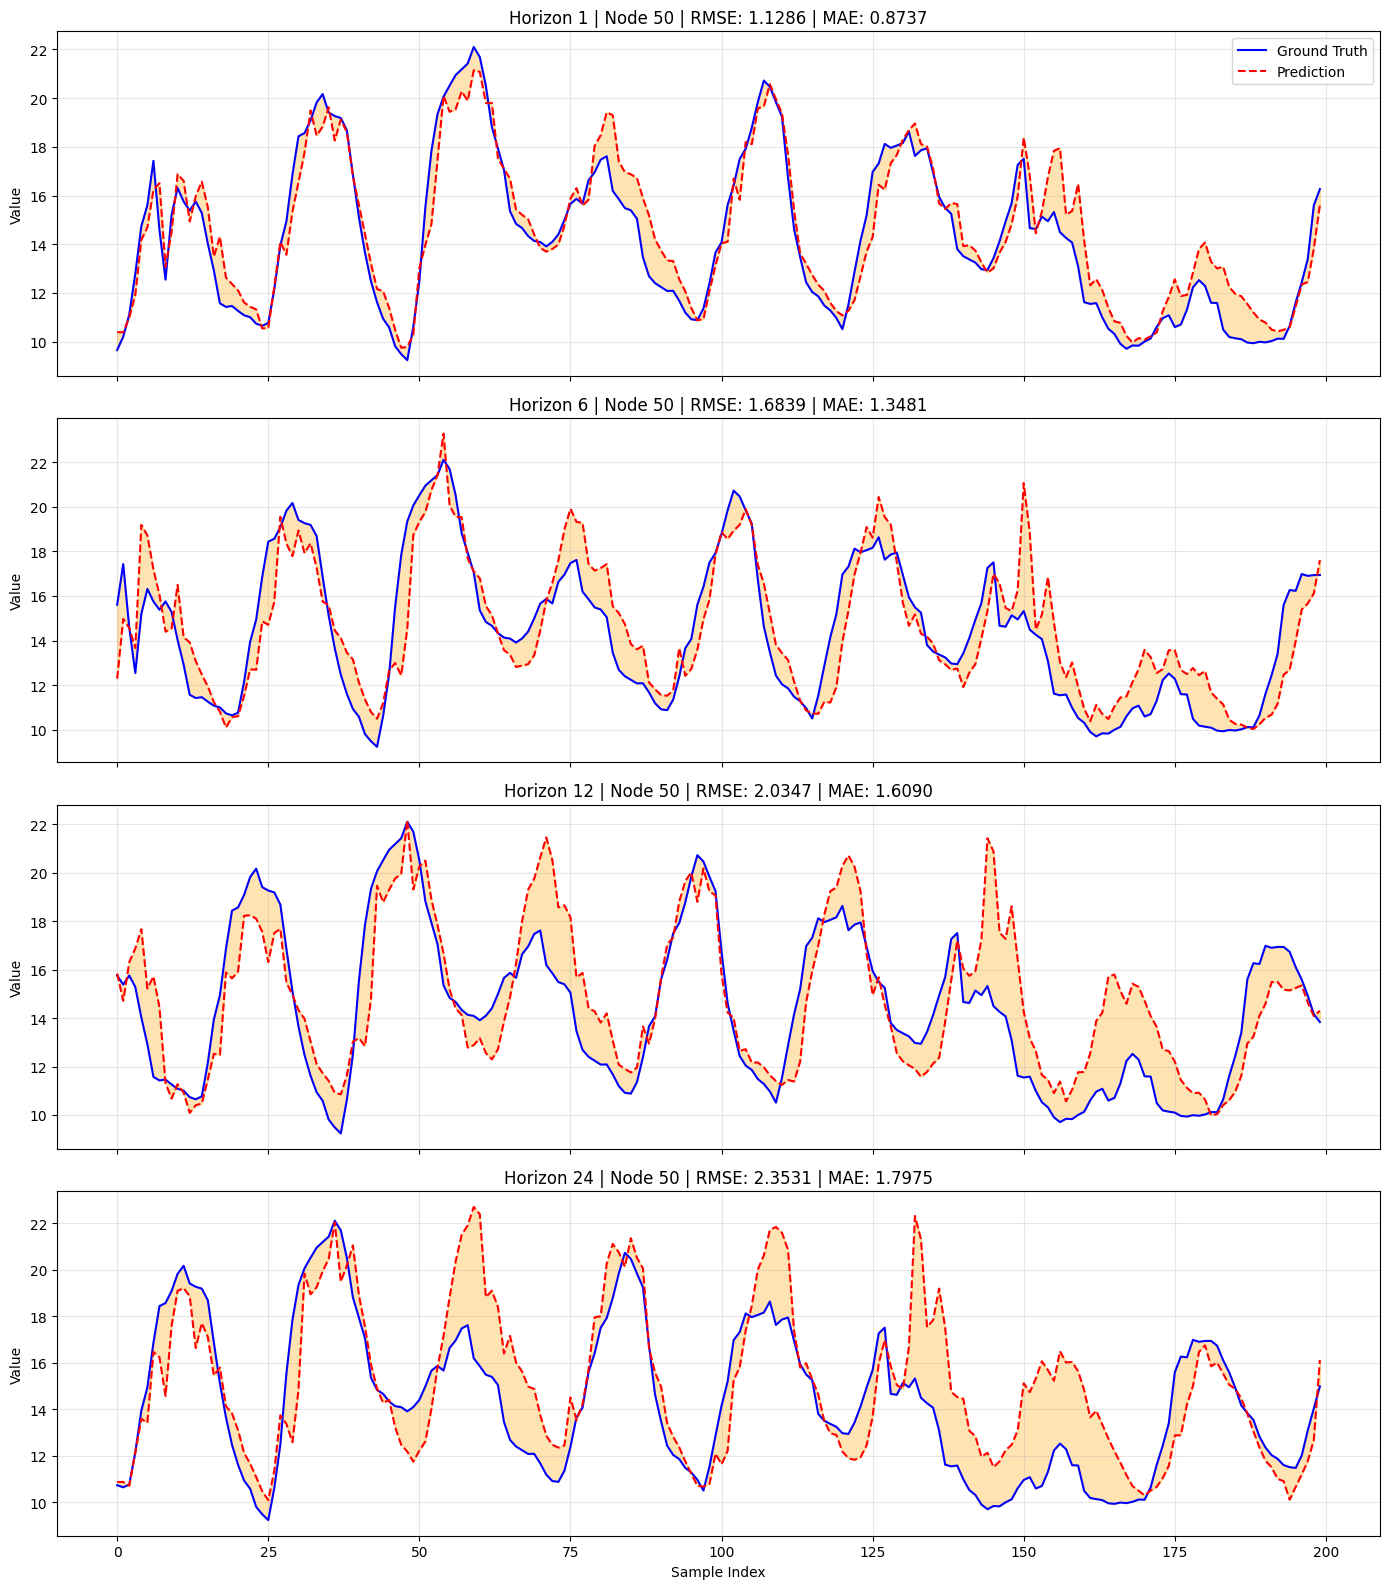

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def plot_pred(node_idx = 10, horizons=[1, 6, 12, 24], num_windows=200, starting_window = 100, channel_idx=0):
    y_all = np.concatenate([batch['y'] for batch in pred], axis=0)        # shape: (total_samples, horizon, nodes, features)
    y_hat_all = np.concatenate([batch['y_hat'] for batch in pred], axis=0)

    # Step 2: Set up visualization parameters
    h_indices = [h - 1 for h in horizons]  # Convert to 0-based


    # Step 3: Plot
    fig, axs = plt.subplots(len(horizons), 1, figsize=(14, 4 * len(horizons)), sharex=True)

    for i, h in enumerate(h_indices):
        y_true = y_all[starting_window:starting_window+num_windows, h, node_idx, channel_idx]
        y_pred = y_hat_all[starting_window:starting_window+num_windows, h, node_idx, channel_idx]
        x = np.arange(len(y_true))

        ax = axs[i] if len(horizons) > 1 else axs
        ax.plot(x, y_true, label='Ground Truth', color='blue')
        ax.plot(x, y_pred, label='Prediction', color='red', linestyle='--')
        ax.fill_between(x, y_true, y_pred, color='orange', alpha=0.3)

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        ax.set_title(f'Horizon {h+1} | Node {node_idx} | RMSE: {rmse:.4f} | MAE: {mae:.4f}')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
        if i == 0:
            ax.legend()

    plt.xlabel('Sample Index')
    plt.tight_layout()
    plt.show()

plot_pred(100)
plot_pred(50)


In [ ]:
import torch
import numpy as np

# Assume `pred` is a list of dicts, each with keys 'y', 'y_hat', 'mask'
# and that each value is a tensor of shape (batch, horizon, nodes, channels)

# 1) Extract lists of tensors
y_hats = [batch['y_hat'] for batch in pred]
ys     = [batch['y']     for batch in pred]
masks  = [batch['mask']  for batch in pred]

# 2) Concatenate along the batch dimension (dim=0)
all_y_hat = torch.cat(y_hats, dim=0)   # shape: (total_samples, horizon, nodes, channels)
all_y     = torch.cat(ys,     dim=0)
all_mask  = torch.cat(masks,  dim=0)

# 3) (Optional) move to CPU and convert to numpy
y_hat_np = all_y_hat.cpu().numpy()
y_np     = all_y.cpu().numpy()
mask_np  = all_mask.cpu().numpy()

# 4) Save to disk
#   a) Using numpy .npz to bundle all three arrays:
np.savez(
    "predictions.npz",
    y_hat=y_hat_np,
    y_true=y_np,
    mask=mask_np
)

#   b) Or using torch for a single file:
torch.save(
    {
        'y_hat': all_y_hat,
        'y':      all_y,
        'mask':   all_mask
    },
    "predictions.pt"
)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def get_metric_dataframe(npz_path: str, metric: str) -> pd.DataFrame:
    """
    Load predictions from an NPZ file and compute a DataFrame of the chosen metric
    per node and per horizon.

    Parameters
    ----------
    npz_path : str
        Path to the NPZ file containing 'y_hat', 'y_true', and optional 'mask'.
    metric : str
        One of 'rmse', 'mae', or 'r2'. Determines which metric to compute.

    Returns
    -------
    pd.DataFrame
        A DataFrame indexed by node, columns are horizons (e.g. '1h', '2h', ...),
        containing the specified metric.
    """
    # Load arrays
    data = np.load(npz_path)
    y_hat = data["y_hat"]    # shape: (n_samples, n_horizons, n_nodes, channels)
    y_true = data["y_true"]
    mask = data.get("mask", None)

    # Define metric function
    metric_funcs = {
        "rmse": lambda t, p: np.sqrt(mean_squared_error(t, p)),
        "mae":  lambda t, p: mean_absolute_error(t, p),
        "r2":   lambda t, p: r2_score(t, p),
        "smape": lambda t, p: 200 * np.mean(np.abs(t - p) / (np.abs(t) + np.abs(p)))
    }
    if metric not in metric_funcs:
        raise ValueError(f"Unsupported metric '{metric}'. Choose from {list(metric_funcs.keys())}.")

    func = metric_funcs[metric]
    n_samples, n_horizons, n_nodes, channels = y_true.shape

    records = []
    for node in range(n_nodes):
        for h in range(n_horizons):
            y_t = y_true[:, h, node, :].ravel()
            y_p = y_hat[:, h, node, :].ravel()
            if mask is not None:
                m = mask[:, h, node, :].ravel().astype(bool)
                y_t = y_t[m]
                y_p = y_p[m]
            if y_t.shape[0] > 0 and y_p.shape[0]>0:
                score = func(y_t, y_p)
            else: score=np.nan
            records.append({"node": node, "horizon": h + 1, metric: score})

    df = pd.DataFrame(records)
    df_pivot = df.pivot(index="node", columns="horizon", values=metric)
    df_pivot.columns = [f"{h}h" for h in df_pivot.columns]
    return df_pivot

path = r"/content/predictions.npz"
df_rmse = get_metric_dataframe(path, metric="rmse")
df_mae  = get_metric_dataframe(path, metric="mae")
df_r2   = get_metric_dataframe(path, metric="r2")
df_smape = get_metric_dataframe(path, metric="smape")


In [ ]:
import matplotlib.pyplot as plt
df_rmse.mean()

,0
1h,1.354105
2h,1.581172
3h,1.832986
4h,1.951436
5h,2.032573
6h,2.106181
7h,2.186576
8h,2.243266
9h,2.299695
10h,2.339492


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

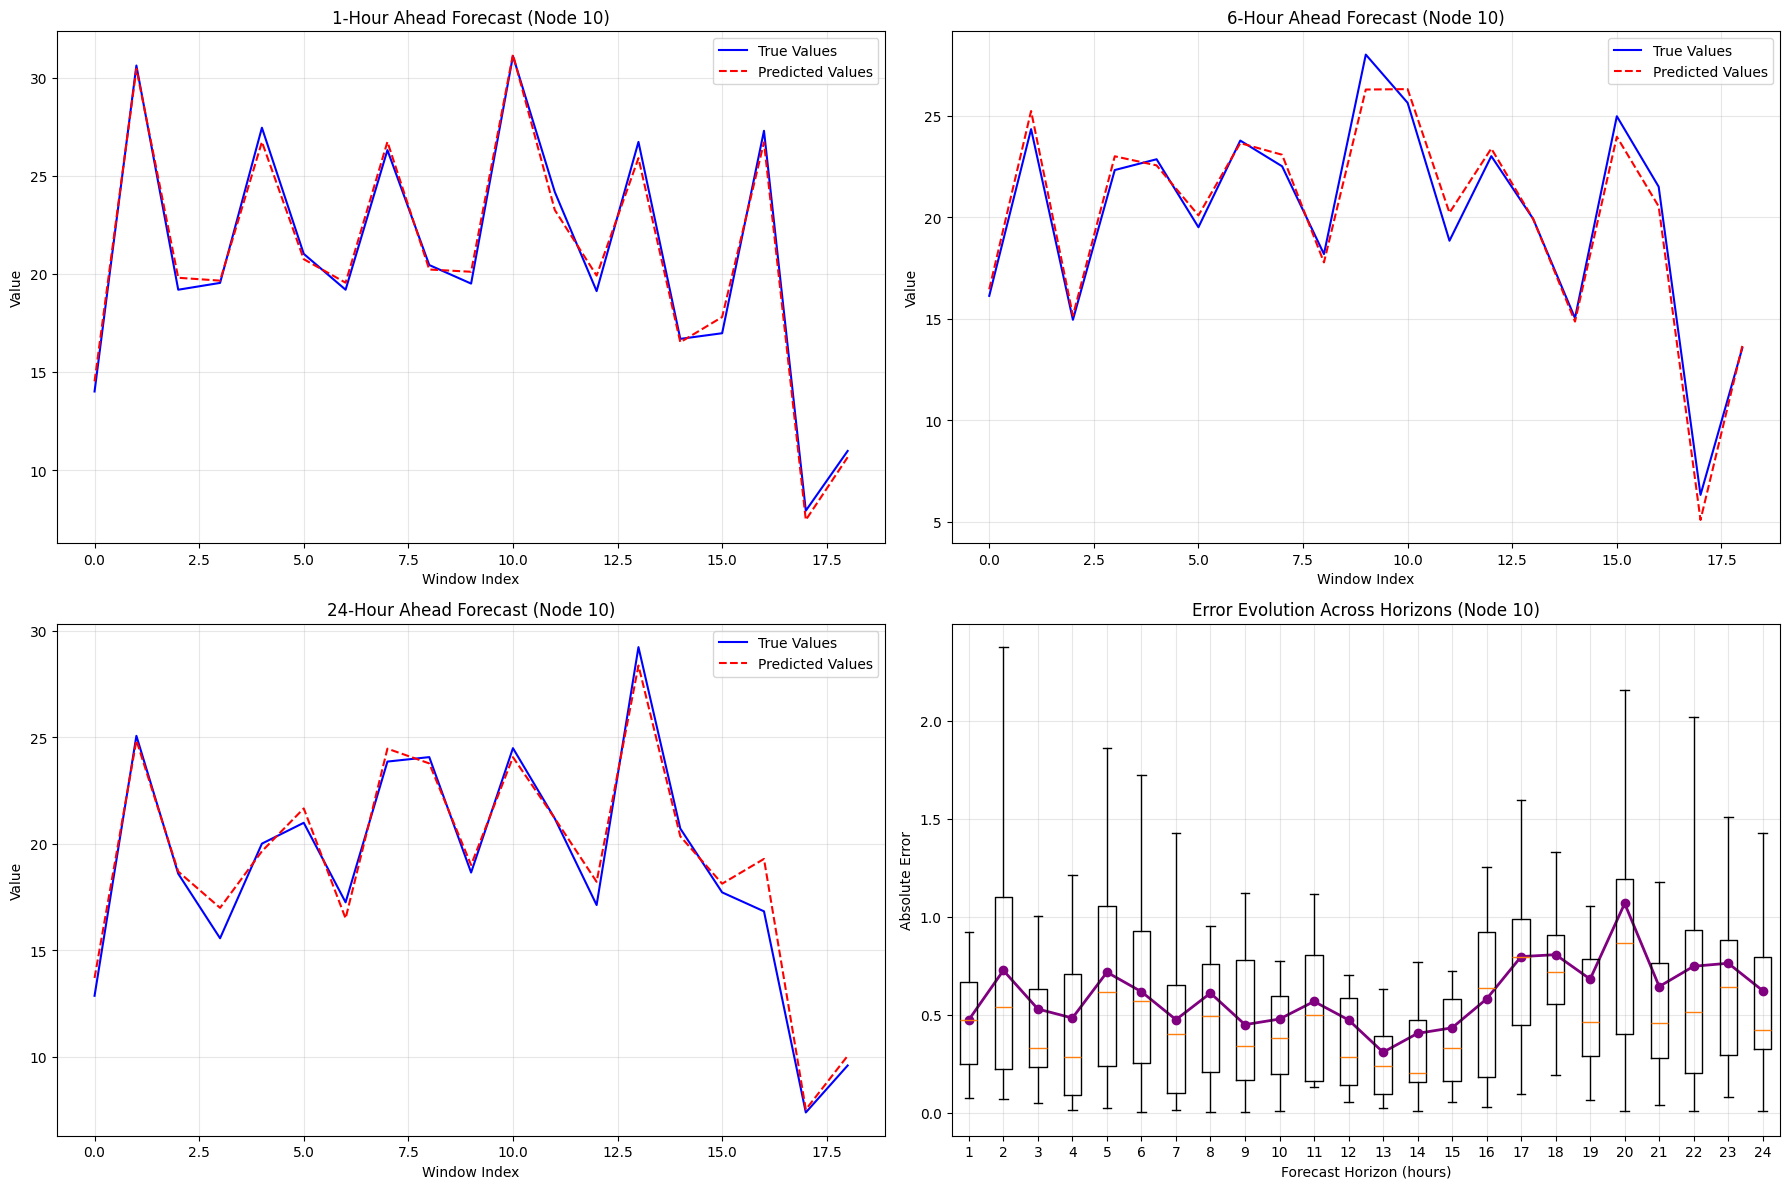

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_forecasts_and_errors(trainer, predictor, datamodule, node_idx=10, feature_idx=0,
                                   horizons=[1, 6, 24], num_windows=100):
    """
    Visualize forecasts at multiple horizons and error evolution for a specific node.

    Creates 4 plots:
    1. Forecast at horizon 1 over time windows
    2. Forecast at horizon 6 over time windows
    3. Forecast at horizon 24 over time windows
    4. Evolution of error across forecast horizons

    Parameters:
    -----------
    trainer : PyTorch Lightning Trainer
        The trained model's trainer
    predictor : PyTorch Lightning Module
        The prediction model
    datamodule : PyTorch Lightning DataModule
        Data module containing test data
    node_idx : int
        The node index to visualize (default: 10)
    feature_idx : int
        The feature index to visualize (default: 0)
    horizons : list
        List of horizons to visualize and compare (default: [1, 6, 24])
    num_windows : int
        Number of consecutive windows to process (default: 100)
    """
    # Create figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # For storing error metrics for the final plot
    all_horizons = list(range(1, max(horizons) + 1))
    mean_errors = []

    # Get test dataloader
    test_loader = datamodule.test_dataloader()
    predictions = trainer.predict(predictor, dataloaders=test_loader)

    # Process predictions for all horizons at once to avoid redundant computation
    all_true_values = {}
    all_pred_values = {}

    # First, extract predictions for all required horizons
    for h in all_horizons:
        h_idx = h - 1  # Convert to 0-indexed

        # Extract values for this horizon
        horizon_true = []
        horizon_pred = []

        for i, pred_output in enumerate(predictions):
            if i >= num_windows:
                break

            y = pred_output['y']  # [batch_size, time_steps, nodes, features]
            y_hat = pred_output['y_hat']  # [batch_size, time_steps, nodes, features]

            # Skip if horizon is out of range
            if h_idx >= y.shape[1]:
                continue

            # Store only the specified horizon for the specific node/feature
            sample_idx = 0
            horizon_true.append(y[sample_idx, h_idx, node_idx, feature_idx].cpu().numpy())
            horizon_pred.append(y_hat[sample_idx, h_idx, node_idx, feature_idx].cpu().numpy())

        # Store extracted values
        if horizon_true:
            all_true_values[h] = np.array(horizon_true)
            all_pred_values[h] = np.array(horizon_pred)

            # Calculate error for this horizon
            errors = np.abs(all_true_values[h] - all_pred_values[h])
            mean_errors.append(np.mean(errors))

    # Plot horizons 1, 6, 24 (or available horizons from the specified list)
    plot_positions = [(0, 0), (0, 1), (1, 0)]

    for i, horizon in enumerate([h for h in horizons if h in all_true_values]):
        # Get axis for this plot
        row, col = plot_positions[i]
        ax = axes[row, col]

        # Get data for this horizon
        true_values = all_true_values[horizon]
        pred_values = all_pred_values[horizon]

        # Plot true vs predicted
        time_axis = np.arange(len(true_values))
        ax.plot(time_axis, true_values, 'b-', label='True Values', linewidth=1.5)
        ax.plot(time_axis, pred_values, 'r--', label='Predicted Values', linewidth=1.5)

        # Add title and labels
        ax.set_title(f'{horizon}-Hour Ahead Forecast (Node {node_idx})', fontsize=12)
        ax.set_xlabel('Window Index', fontsize=10)
        ax.set_ylabel('Value', fontsize=10)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)

    # Plot error evolution across horizons in the final subplot
    ax = axes[1, 1]

    # Plot mean absolute error vs horizon
    ax.plot(all_horizons, mean_errors, 'o-', color='purple', linewidth=2)

    # Add boxplots for error distribution
    boxplot_data = [np.abs(all_true_values[h] - all_pred_values[h]) for h in all_horizons if h in all_true_values]
    if boxplot_data:
        ax.boxplot(boxplot_data, positions=all_horizons[:len(boxplot_data)], widths=0.5, showfliers=False)

    # Add title and labels
    ax.set_title(f'Error Evolution Across Horizons (Node {node_idx})', fontsize=12)
    ax.set_xlabel('Forecast Horizon (hours)', fontsize=10)
    ax.set_ylabel('Absolute Error', fontsize=10)
    ax.grid(True, alpha=0.3)

    # Finish the figure
    plt.tight_layout()
    plt.savefig(f'forecast_analysis_node{node_idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

    return {
        'true_values': all_true_values,
        'pred_values': all_pred_values,
        'mean_errors': dict(zip(all_horizons, mean_errors))
    }

# Example usage:
results = visualize_forecasts_and_errors(trainer, predictor, dm, node_idx=10)

In [ ]:
timeseries_hourly_clean.reset_index(names=['datetime'], inplace=True)

In [ ]:
timeseries_hourly_clean['hour'] = timeseries_hourly_clean['datetime'].dt.hour


In [ ]:
true_temp_means = timeseries_hourly_clean.groupby('hour').mean().drop(columns=['datetime']).mean(axis=1)

<Axes: xlabel='hour'>

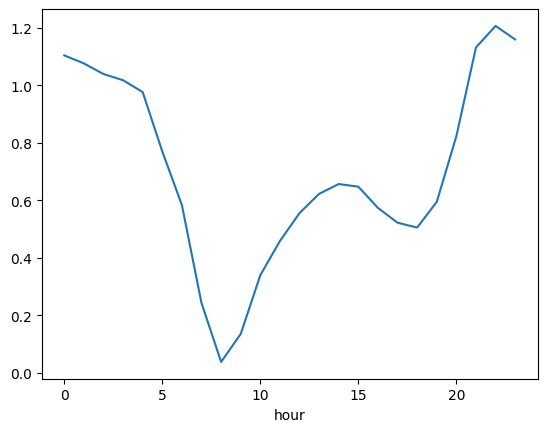

In [ ]:
true_temp_means.plot()

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


Processing test batches: 100%|██████████| 23/23 [00:00<00:00, 274.13it/s]


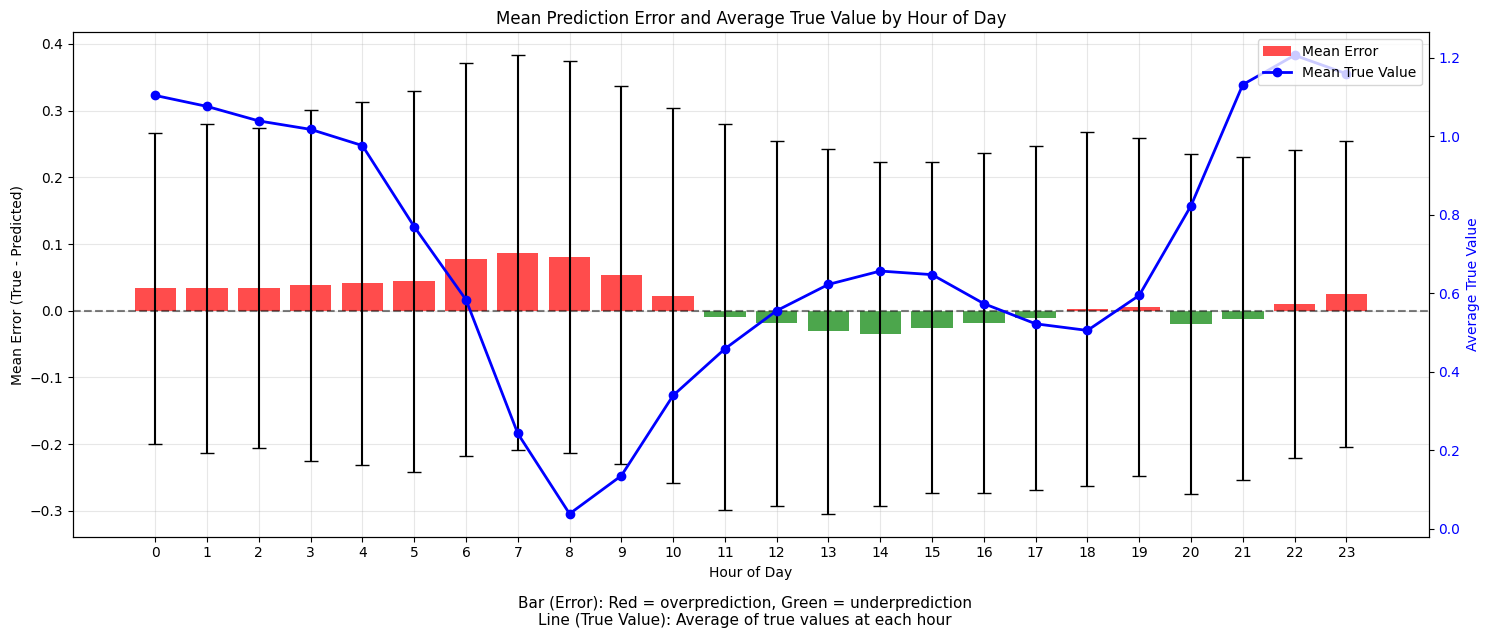

In [ ]:


def visualize_error_by_hour(trainer, predictor, datamodule, feature_idx=0, true_mean=None):
    """
    Visualize mean error and average true value by hour of day across the test set.
    Positive errors indicate underprediction, negative errors indicate overprediction.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    from tqdm import tqdm
    import pandas as pd

    # Create test dataloader
    test_loader = datamodule.test_dataloader()

    # Initialize collectors
    hourly_errors = [[] for _ in range(24)]
    if true_mean is None:         # Mean prediction error by hour
      hourly_true_values = [[] for _ in range(24)]    # Mean true values by hour
    else:
      hourly_true_values = true_mean

    current_hour = 0
    predictions = trainer.predict(predictor, dataloaders=test_loader)

    with torch.no_grad():
        for pred in tqdm(predictions, desc="Processing test batches"):
            y = pred['y']
            y_hat = pred['y_hat']

            errors = y.cpu().numpy() - y_hat.cpu().numpy()
            y_true = y.cpu().numpy()

            for i in range(errors.shape[0]):
                # Mean error and true value across nodes at this time step
                batch_errors = errors[i, :, :, feature_idx]
                batch_true = y_true[i, :, :, feature_idx]

                mean_error = np.mean(batch_errors)
                mean_true = np.mean(batch_true)

                hourly_errors[current_hour].append(mean_error)
                if true_mean is None:
                  hourly_true_values[current_hour].append(mean_true)

                current_hour = (current_hour + 1) % 24
    # Final aggregation
    mean_hourly_errors = [np.mean(hour_errors) if hour_errors else 0 for hour_errors in hourly_errors]
    std_hourly_errors = [np.std(hour_errors) if hour_errors and len(hour_errors) > 1 else 0 for hour_errors in hourly_errors]
    mean_hourly_true_values = [np.mean(hour_vals) if hour_vals else 0 for hour_vals in hourly_true_values]

    hours = np.arange(24)

    # Plotting
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Bar plot: Mean prediction error
    bar_colors = ['green' if e < 0 else 'red' for e in mean_hourly_errors]
    ax1.bar(hours, mean_hourly_errors, yerr=std_hourly_errors, alpha=0.7, capsize=5, color=bar_colors, label='Mean Error')
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Mean Error (True - Predicted)', color='black')
    ax1.tick_params(axis='y')
    ax1.grid(True, alpha=0.3)

    # Line plot: Mean true values
    ax2 = ax1.twinx()
    ax2.plot(hours, mean_hourly_true_values, color='blue', marker='o', linestyle='-', linewidth=2, label='Mean True Value')
    ax2.set_ylabel('Average True Value', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # X-axis
    ax1.set_xticks(hours)

    # Title and legend
    plt.title('Mean Prediction Error and Average True Value by Hour of Day')
    fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

    # Annotation
    plt.figtext(0.5, -0.05,
                'Bar (Error): Red = overprediction, Green = underprediction\n'
                'Line (True Value): Average of true values at each hour',
                ha='center', fontsize=11)

    plt.tight_layout()
    plt.savefig('error_by_hour_with_true_values.png')
    plt.show()

    # Optional: Return data
    results_df = pd.DataFrame({
        'Hour': hours,
        'Mean_Error': mean_hourly_errors,
        'Std_Error': std_hourly_errors,
        'Mean_True_Value': mean_hourly_true_values
    })

    return results_df


# Call the function
hourly_error_df = visualize_error_by_hour(trainer, predictor, dm,true_mean=true_temp_means)
#print(hourly_error_df)

In [ ]:
timestamps_24 = weather_df[weather_df['datetime'] >= pd.to_datetime('2024')]['datetime']

In [ ]:
dm.test_dataloader().batch_size

128

In [ ]:
def visualize_error_by_hour_and_month(trainer, predictor, datamodule, timestamp, feature_idx=0, ):
    """
    Visualize mean error by hour of day and month in a 2D heatmap across the test set.
    Positive errors (red) indicate underprediction,
    negative errors (green) indicate overprediction.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    from tqdm import tqdm
    import pandas as pd
    import seaborn as sns


    test_loader = datamodule.test_dataloader()

    data_records = []

    predictions = trainer.predict(predictor, dataloaders=test_loader)
    batch_size = test_loader.batch_size

    with torch.no_grad():
        for batch_idx, pred in enumerate(tqdm(predictions, desc="Processing test batches")):

            y = pred['y']       # true
            y_hat = pred['y_hat']  # pred


            start_index = batch_idx * batch_size
            end_index = start_index + y.shape[0]
            timestamps_batch = timestamp[start_index:end_index]


            y_np = y.cpu().numpy()
            y_hat_np = y_hat.cpu().numpy()

            # Calculate errors
            errors = y_np - y_hat_np  # shape: (batch_size, time, num_nodes, num_features)

            # For each sample in the batch
            batch_size, T, num_nodes, num_feats = errors.shape
            for i in range(batch_size):
                for t in range(T):
                    # Compute mean error across all nodes for the chosen feature
                    mean_error = np.mean(errors[i, t, :, feature_idx])

                    # Extract timestamp for this sample
                    try:  # Add a try-except block to handle potential index errors
                        current_timestamp = timestamps_batch.iloc[i]
                    except IndexError:
                        print(f"IndexError: i={i}, batch_size={batch_size}, timestamps_batch length={len(timestamps_batch)}")
                        continue  # Skip this iteration if index is out of bounds

                    current_hour = current_timestamp.hour
                    current_month = current_timestamp.month
                    current_day = current_timestamp.day

                    data_records.append({
                        'hour': current_hour,
                        'day': current_day,
                        'month': current_month,
                        'error': mean_error
                    })


    df = pd.DataFrame(data_records)


    # Group by (month, day, hour) and get mean error
    grouped = df.groupby(['month', 'day', 'hour'])['error'].mean().reset_index()

    # Create a composite index for (month, day)
    grouped['month_day'] = grouped['month'].astype(str).str.zfill(2) + '-' + grouped['day'].astype(str).str.zfill(2)

    # Pivot table: rows = month-day, columns = hour
    pivot = grouped.pivot(index='month_day', columns='hour', values='error')

    # Sort rows chronologically by month-day
    pivot = pivot.sort_index(key=lambda x: pd.to_datetime(x, format='%m-%d'))

    # Plot heatmap
    plt.figure(figsize=(16, 14))

    sns.heatmap(pivot.T, cmap='coolwarm', center=0, cbar_kws={'label': 'Mean Error (True - Predicted)'})

    plt.title('Mean Prediction Error by Day, Month, and Hour')
    plt.ylabel('Hour of Day')
    plt.xlabel('Date (Month-Day)')

    plt.yticks(rotation=0)
    plt.xticks(fontsize=8)

    plt.tight_layout()
    plt.savefig('error_by_day_month_hour.png', dpi=150)
    plt.show()

    return pivot


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


Processing test batches: 100%|██████████| 23/23 [00:01<00:00, 16.27it/s]


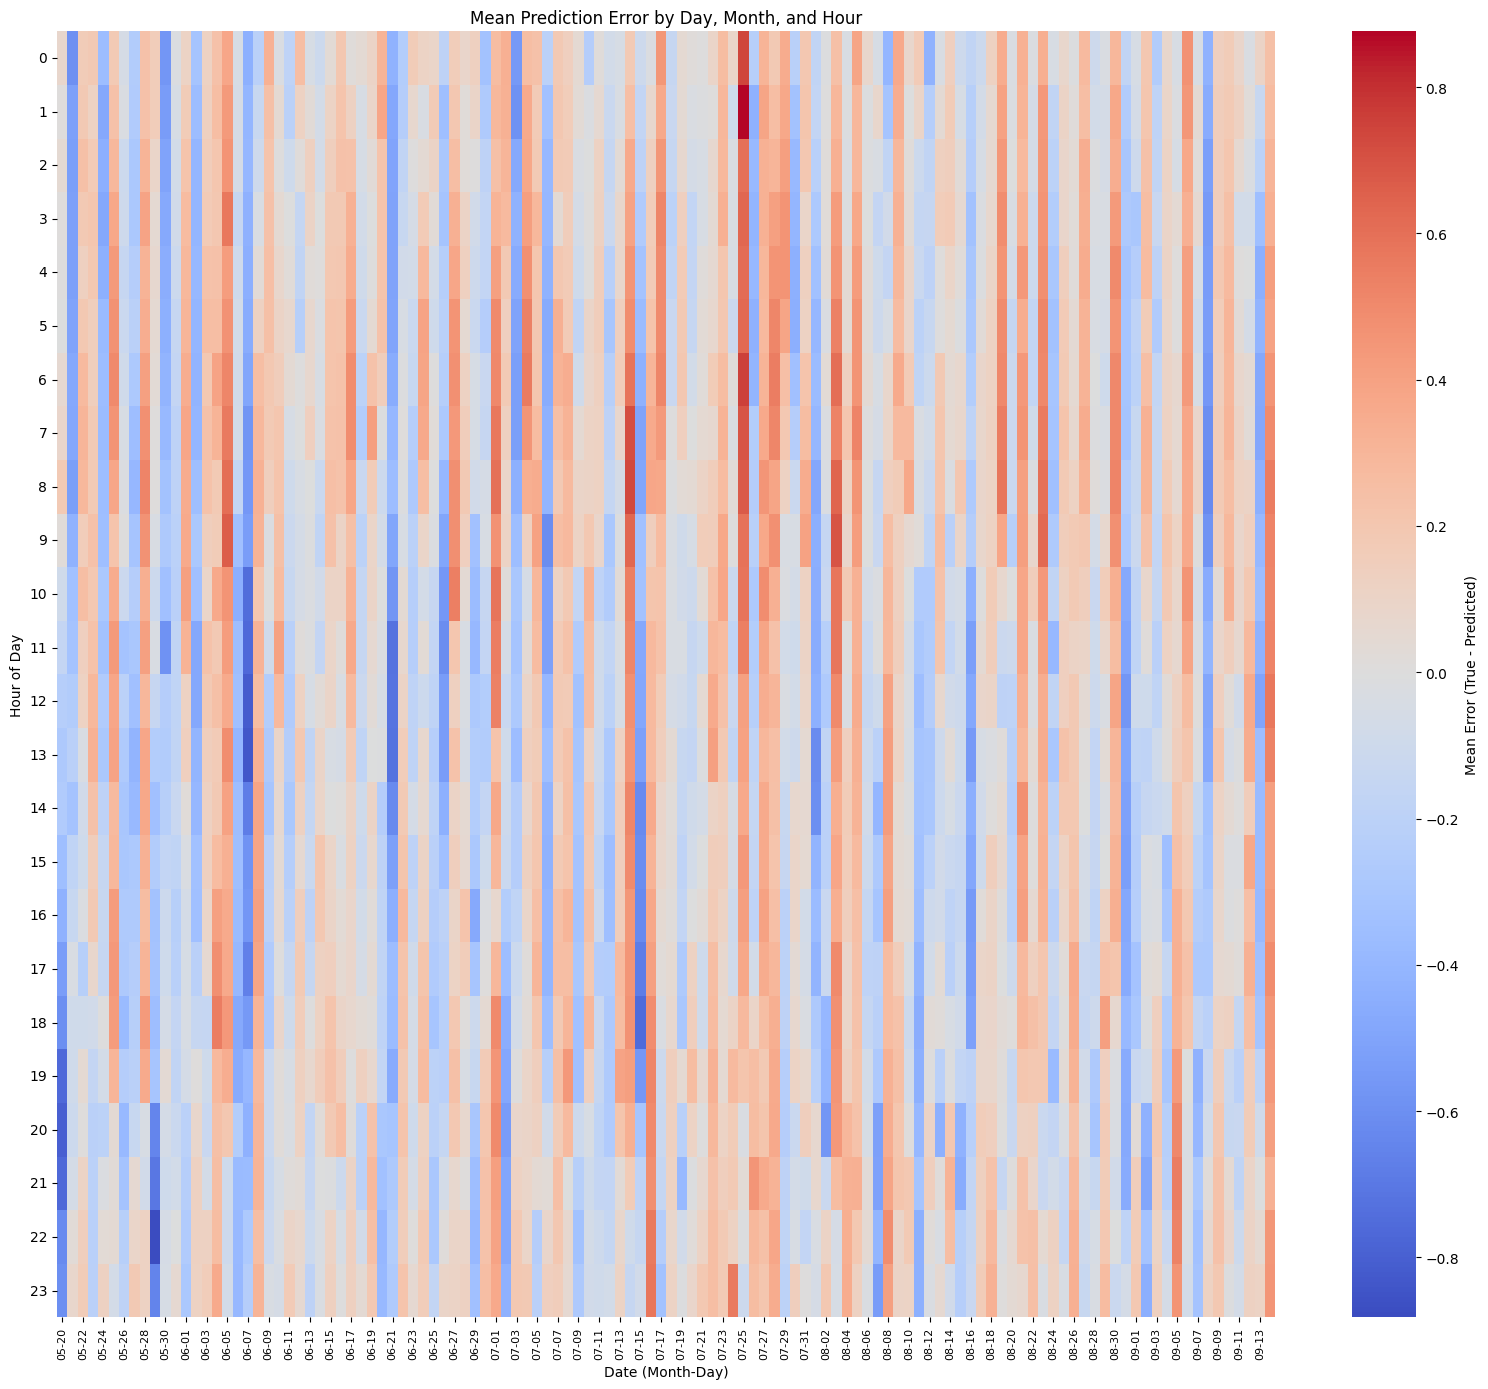

hour             0         1         2         3         4         5   \
month_day                                                               
05-20      0.074980  0.006170  0.050320  0.007738 -0.002722 -0.005414   
05-21     -0.595813 -0.524229 -0.531054 -0.522485 -0.524435 -0.508670   
05-22      0.165617  0.186808  0.240906  0.188936  0.132139  0.192916   
05-23      0.187162  0.115604  0.169838  0.207730  0.190281  0.146107   
05-24     -0.364974 -0.481050 -0.443530 -0.481362 -0.436632 -0.377968   
...             ...       ...       ...       ...       ...       ...   
09-10      0.164362  0.176149  0.209175  0.239765  0.273419  0.301701   
09-11      0.085998  0.122460  0.053350 -0.072980  0.004449  0.026984   
09-12     -0.025910  0.019625 -0.026873 -0.075974 -0.003726 -0.058079   
09-13      0.100546 -0.134730 -0.200982 -0.346571 -0.447102 -0.417619   
09-14      0.243157  0.265274  0.301566  0.331978  0.413331  0.391385   

hour             6         7         8         9  

In [ ]:
# Call the function
hour_month_pivot = visualize_error_by_hour_and_month(trainer, predictor, dm, timestamp=timestamps_24)

# If you want to inspect the pivot table directly
print(hour_month_pivot)